In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleandata/test_features.csv
/kaggle/input/cleandata/train_features.csv
/kaggle/input/train-set/patients.csv
/kaggle/input/train-set/conditions.csv
/kaggle/input/train-set/devices.csv
/kaggle/input/train-set/allergies.csv
/kaggle/input/train-set/imaging_studies.csv
/kaggle/input/train-set/immunizations.csv
/kaggle/input/test-set/patients.csv
/kaggle/input/test-set/conditions.csv
/kaggle/input/test-set/devices.csv
/kaggle/input/test-set/allergies.csv
/kaggle/input/test-set/imaging_studies.csv
/kaggle/input/test-set/immunizations.csv


In [44]:
train_set = pd.read_csv('/kaggle/input/train-set/conditions.csv')
test_set = pd.read_csv('/kaggle/input/test-set/conditions.csv')
train_patient = pd.read_csv('/kaggle/input/train-set/patients.csv')
test_patient = pd.read_csv('/kaggle/input/test-set/patients.csv')

# patient file

In [45]:
train_patient[['BIRTHDATE','DEATHDATE']] = train_patient[['BIRTHDATE','DEATHDATE']].astype('datetime64[ns]')
test_patient[['BIRTHDATE','DEATHDATE']] = test_patient[['BIRTHDATE','DEATHDATE']].astype('datetime64[ns]')

In [46]:
from datetime import datetime
  
def calculateAge(index,file): 
    days_in_year = 365
    if str( file.at[index,'DEATHDATE']) == 'NaT':
        age = int((datetime.now() - file.at[index,'BIRTHDATE']).days / days_in_year)
    else:
        age = int((file.at[index,'DEATHDATE'] - file.at[index,'BIRTHDATE']).days / days_in_year)
    return age 

In [47]:
train_patient['AGE']=np.nan
for i in range(len(train_patient)):
    train_patient.at[i,'AGE'] = calculateAge(i,train_patient)
    
test_patient['AGE']=np.nan
for i in range(len(test_patient)):
    test_patient.at[i,'AGE'] = calculateAge(i,test_patient)

In [48]:
def check_death(index,file):
    date = '2020-01-01'
    my_date = datetime.strptime(date, "%Y-%m-%d")
    if str( file.at[index,'DEATHDATE']) == 'NaT':
        sta = True # ALIVE
    elif (int((file.at[index,'DEATHDATE'] - my_date).days)>0):
        sta = False # DEAD AFTER 2020
    else:
        sta = 'DB' #DEAD BEFORE 2020
    return sta

In [49]:
train_patient['DEATH_2020']=''
for i in range(len(train_patient)):
    train_patient.at[i,'DEATH_2020'] = check_death(i,train_patient)

test_patient['DEATH_2020']=''
for i in range(len(test_patient)):
    test_patient.at[i,'DEATH_2020'] = check_death(i,test_patient)

In [50]:
a,da,db = train_patient[train_patient['DEATH_2020']==True]['DEATH_2020'].count(),train_patient[train_patient['DEATH_2020']==False]['DEATH_2020'].count(),train_patient[train_patient['DEATH_2020']=='DB']['DEATH_2020'].count()
a,da,db

(79999, 5939, 32021)

In [51]:
ta,tda,tdb = test_patient[test_patient['DEATH_2020']==True]['DEATH_2020'].count(),test_patient[test_patient['DEATH_2020']==False]['DEATH_2020'].count(),test_patient[test_patient['DEATH_2020']=='DB']['DEATH_2020'].count()
ta,tda,tdb

(21479, 0, 8013)

In [52]:
train_final_features = train_patient[['Id','AGE','DEATH_2020']]
test_final_features = test_patient[['Id','AGE','DEATH_2020']]

In [53]:
train_final_features.index=train_final_features['Id']
test_final_features.index=test_final_features['Id']

# condition_list

In [54]:
code_description =list(set(zip(train_set['CODE'],train_set['DESCRIPTION'])))

# condition file

840544004 suspect
840539006 comfirmed


In [55]:
train_columns_name = train_set['CODE'].unique().tolist()
train_columns_name.insert(0,'PATIENT')
train_features = pd.DataFrame(columns = train_columns_name)
train_features['PATIENT'] = train_set['PATIENT'].unique().tolist()
train_features.index=train_features['PATIENT']

test_columns_name = test_set['CODE'].unique().tolist()
test_columns_name.insert(0,'PATIENT')
#what columns?
test_features = pd.DataFrame(columns = test_columns_name)
test_features['PATIENT'] = test_set['PATIENT'].unique().tolist()
test_features.index=test_features['PATIENT']

In [56]:
for i in train_set.index:
    train_features.at[train_set.at[i,'PATIENT'], train_set.at[i,'CODE']]=True

for i in test_set.index:
    test_features.at[test_set.at[i,'PATIENT'], test_set.at[i,'CODE']]=True

In [57]:
train_features = train_features.fillna(False)
test_features = test_features.fillna(False)

In [58]:
related = [449868002,233604007,65710008]
train_features['related'] = (train_features[449868002] & train_features[233604007])| (train_features[449868002]& train_features[65710008])
test_features['related'] = (test_features[449868002] & test_features[233604007])|(test_features[449868002] & test_features[65710008])

# merge

target: train_features[840539006]

In [59]:
train_final_features = train_final_features.merge(train_features,how='outer',left_index=True, right_index=True)
test_final_features = test_final_features.merge(test_features,how='outer',left_index=True, right_index=True)

In [60]:
notest = []
for i in train_columns_name:
    if i not in test_columns_name:
        notest.append(i)

In [61]:
notest_list = []
for code in notest:
    description = list(filter(lambda x:code in x, code_description))[0][1]
    notest_list.append(description)
notest_list


['Nasal congestion (finding)',
 'Cough (finding)',
 'Chill (finding)',
 'Fever (finding)',
 'Suspected COVID-19',
 'Sore throat symptom (finding)',
 'Sputum finding (finding)',
 'Fatigue (finding)',
 'Dyspnea (finding)',
 'Wheezing (finding)',
 'COVID-19',
 'Hypoxemia (disorder)',
 'Respiratory distress (finding)',
 'Acute deep venous thrombosis (disorder)',
 'Loss of taste (finding)',
 'Nausea (finding)',
 'Vomiting symptom (finding)',
 'Headache (finding)',
 'Sepsis caused by virus (disorder)',
 'Septic shock (disorder)',
 'Heart failure (disorder)',
 'Acute respiratory distress syndrome (disorder)',
 'Bacterial infectious disease (disorder)',
 'Acute pulmonary embolism (disorder)',
 'Muscle pain (finding)',
 'Joint pain (finding)',
 'Acquired coagulation disorder (disorder)',
 'Injury of kidney (disorder)',
 'Diarrhea symptom (finding)',
 'Injury of heart (disorder)',
 'Passive conjunctival congestion (finding)',
 'Hemoptysis (finding)',
 'Non-small cell carcinoma of lung  TNM stage

In [62]:
notest.remove(840539006)

In [63]:
train_final_features = train_final_features.drop(notest,axis='columns')

In [64]:
train_final_features = train_final_features.fillna(False)
test_final_features = test_final_features.fillna(False)

In [65]:
train_final_features = train_final_features.drop(['PATIENT'],axis='columns')
test_final_features = test_final_features.drop(['PATIENT'],axis='columns')

In [66]:
from sklearn.datasets import load_digits
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [67]:
model_features = train_final_features[train_final_features['DEATH_2020']!='DB'].drop(['Id'],axis='columns')
test_model_features = test_final_features[test_final_features['DEATH_2020']!='DB'].drop(['Id'],axis='columns')

# model

In [68]:
X_train, X_test, y_train,y_test = train_test_split(model_features.drop([840539006],axis='columns'),model_features[840539006],test_size=0.3,random_state = 42)
model = RandomForestClassifier(n_estimators=40,oob_score = True, random_state=42)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.8397331471569311

In [69]:
model.oob_score_

0.8291442250149611

In [70]:
y_predicted = model.predict(X_test)

Text(69.0, 0.5, 'Truth')

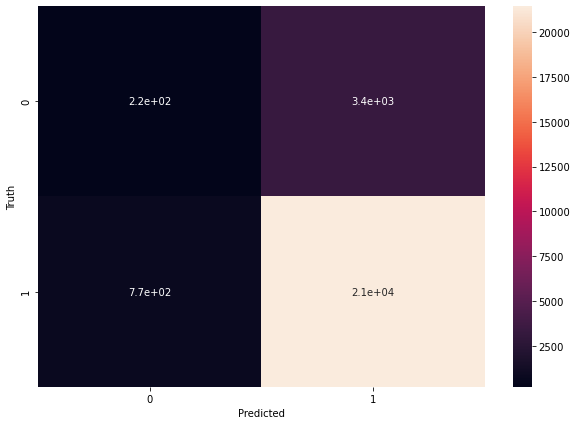

In [71]:
cm = confusion_matrix(y_test,y_predicted)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# imbalance data

In [72]:
model_features[840539006].value_counts()

True     73697
False    12241
Name: 840539006, dtype: int64

In [73]:
from sklearn.utils import resample

model_features_majority = model_features[model_features[840539006]==True]
model_features_minority = model_features[model_features[840539006]==False]
 
# Upsample minority class
model_features_minority_upsampled = resample(model_features_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=73697)    # to match majority class
 
# Combine majority class with upsampled minority class
model_features_upsampled = pd.concat([model_features_majority, model_features_minority_upsampled])
 
# Display new class counts
model_features_upsampled[840539006].value_counts()

True     73697
False    73697
Name: 840539006, dtype: int64

In [74]:
model_features_upsampled.to_csv('train_features.csv')
test_model_features.to_csv('test_features.csv')

In [75]:
rX_train, rX_test, ry_train,ry_test = train_test_split(model_features_upsampled.drop([840539006],axis='columns'),model_features_upsampled[840539006],test_size=0.3,random_state = 42)
rmodel = RandomForestClassifier(n_estimators=40,oob_score = True, random_state = 42)
rmodel.fit(rX_train, ry_train)
rmodel.score(rX_test,ry_test)

0.8832628508107375

In [76]:
rmodel.oob_score_

0.8731669493578871

In [77]:
from sklearn.metrics import accuracy_score
accuracy_score(ry_test,rmodel.predict(rX_test))

0.8832628508107375

Text(69.0, 0.5, 'Truth')

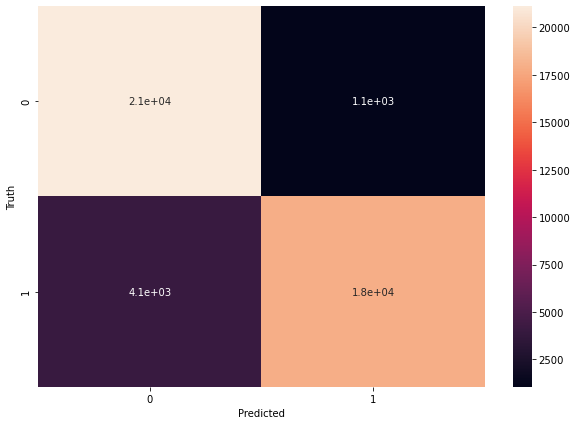

In [78]:
ry_predicted = rmodel.predict(rX_test)
rcm = confusion_matrix(ry_test,ry_predicted)
plt.figure(figsize=(10,7))
sn.heatmap(rcm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Model Tuning

In [79]:
from sklearn.model_selection import RandomizedSearchCV

In [112]:
def param_Search_CV(X_train, y_train):
    estimator = RandomForestClassifier()
    param_grid = {
        'n_estimators':[100,200,300],
            "max_features" : ["auto", "sqrt", "log2"],
            #"max_features" : [20, 30, 40],
            "max_depth"     : [50, 100, None],
           'min_samples_leaf':[1],
           'min_samples_split':[2],
            "bootstrap": [True, False],
            }

    grid = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
    grid.fit(X_train, y_train)
    return grid.best_score_ , grid.best_params_

SyntaxError: invalid syntax (<ipython-input-112-01ebb76e61e8>, line 5)

In [81]:
score, params = param_Search_CV(rX_train, ry_train)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [82]:
score

0.8321686455052095

In [83]:
params

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

best_params
{'n_estimators': 500,
 'min_samples_split': 15,
 'min_samples_leaf': 12,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [84]:
brmodel = RandomForestClassifier(n_estimators=500,min_samples_split = 15, 
                                 min_samples_leaf = 12, max_features = 'auto', 
                                 max_depth = None, oob_score = True, n_jobs=-1,random_state = 42)
brmodel.fit(rX_train, ry_train)
brmodel.score(rX_test,ry_test)

0.6576810873154074

In [85]:
rmodel.oob_score_

0.8731669493578871

In [86]:
accuracy_score(ry_test, brmodel.predict(rX_test))

0.6576810873154074

Text(69.0, 0.5, 'Truth')

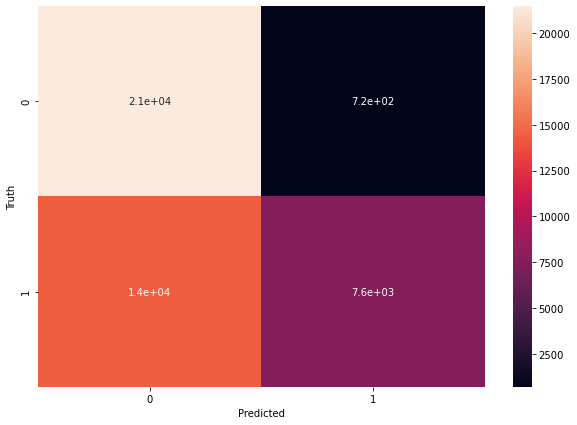

In [87]:
bry_predicted = brmodel.predict(rX_test)
brcm = confusion_matrix(ry_test,bry_predicted)
plt.figure(figsize=(10,7))
sn.heatmap(brcm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# rmodel predict

In [88]:
test_predicted = rmodel.predict(test_model_features)
test_predicted_proba = rmodel.predict_proba(test_model_features)
test_model_features['predicted_proba'] = test_predicted_proba.T[1]
test_model_features['predicted'] = test_predicted

In [89]:
rmodel.oob_score_

0.8731669493578871

In [90]:
rmodel.classes_

array([False,  True])

In [91]:
rm_result = test_model_features[['predicted','predicted_proba']]

In [92]:
test_result = pd.DataFrame(test_final_features['Id'])
test_result = test_result.merge(rm_result,how='outer',left_index=True, right_index=True)

In [93]:
test_result['predicted'] = test_result['predicted'].fillna(False)
test_result['predicted_proba'] = test_result['predicted_proba'].fillna(0)

test_result.to_csv('COVID_19 Status.csv')

In [94]:
test_result.to_csv('COVID_19 Status.csv',index=False)

In [95]:
test_result

,Id,predicted,predicted_proba
0000fc3f-6148-4c1b-84b3-253833fa4b1a,0000fc3f-6148-4c1b-84b3-253833fa4b1a,True,0.697630
0002f1cf-d7f2-4aaa-ab38-92df142b6256,0002f1cf-d7f2-4aaa-ab38-92df142b6256,True,0.691516
0005df11-ceab-478d-a3d8-39b183804397,0005df11-ceab-478d-a3d8-39b183804397,True,0.750000
0006cf42-c915-4439-8966-a9e3b2fa3fc4,0006cf42-c915-4439-8966-a9e3b2fa3fc4,False,0.438683
0009f5f2-b640-4ec5-b9b2-ec4358ca7d76,0009f5f2-b640-4ec5-b9b2-ec4358ca7d76,True,0.551079
...,...,...,...
fff364f5-1b04-4294-829b-10c3f8c932cd,fff364f5-1b04-4294-829b-10c3f8c932cd,False,0.000000
fff3aa04-59db-4b8f-9e48-9f338c18d773,fff3aa04-59db-4b8f-9e48-9f338c18d773,False,0.000000
fff4c3b3-a827-4aaa-8483-046d9aa89206,fff4c3b3-a827-4aaa-8483-046d9aa89206,True,0.725000
fff4fd92-1307-453d-94df-5564f456e045,fff4fd92-1307-453d-94df-5564f456e045,True,0.639340


In [96]:
test_result[['Id','predicted_proba']].to_csv('COVID_19 Status submission.csv',index=False)

In [97]:
test_result['predicted'].value_counts()

True     17987
False    11505
Name: predicted, dtype: int64

In [98]:
17471/29492

0.5923979384239794

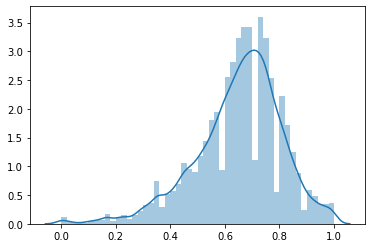

In [99]:
sn.distplot(test_predicted_proba.T[1])

# features selection

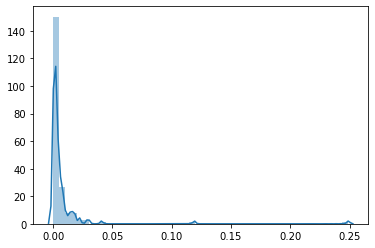

In [100]:
sn.distplot(rmodel.feature_importances_)

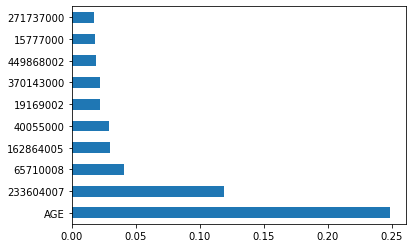

In [101]:
rf_importances = pd.Series(rmodel.feature_importances_, index=rX_train.columns)
rf_importances.nlargest(10).plot(kind='barh')
plt.show()

In [102]:
rf_importances.nlargest(10)

AGE          0.248994
233604007    0.118995
65710008     0.040994
162864005    0.029685
40055000     0.029209
19169002     0.022577
370143000    0.021993
449868002    0.018703
15777000     0.017952
271737000    0.017746
dtype: float64

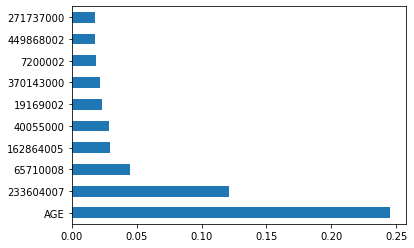

In [103]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
selection = ExtraTreesClassifier()
selection.fit(rX_train, ry_train)
#use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(selection.feature_importances_, index=rX_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [104]:
feat_importances.nlargest(10)

AGE          0.245387
233604007    0.120821
65710008     0.045215
162864005    0.029495
40055000     0.028430
19169002     0.023161
370143000    0.022141
7200002      0.018413
449868002    0.018289
271737000    0.018108
dtype: float64

In [105]:
important_features = list(set(rf_importances.nlargest(10).index.tolist()+feat_importances.nlargest(10).index.tolist()))

In [106]:
len(important_features)

11

In [107]:
features_list = important_features.copy()

In [108]:
features_list

[449868002,
 7200002,
 'AGE',
 162864005,
 233604007,
 15777000,
 271737000,
 19169002,
 370143000,
 65710008,
 40055000]

In [109]:
features_list.pop(features_list.index('AGE'))

'AGE'

In [110]:
important_list = []
for code in features_list:
    description = list(filter(lambda x:code in x, code_description))[0][1]
    important_list.append((code,description))

In [111]:
important_list

[(449868002, 'Smokes tobacco daily'),
 (7200002, 'Alcoholism'),
 (162864005, 'Body mass index 30+ - obesity (finding)'),
 (233604007, 'Pneumonia (disorder)'),
 (15777000, 'Prediabetes'),
 (271737000, 'Anemia (disorder)'),
 (19169002, 'Miscarriage in first trimester'),
 (370143000, 'Major depression disorder'),
 (65710008, 'Acute respiratory failure (disorder)'),
 (40055000, 'Chronic sinusitis (disorder)')]

449868002  233604007  65710008